In [35]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

import psycopg2
from psycopg2 import sql

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import class_weight

%matplotlib inline

In [36]:
#Info for the connection wiht postgres SQL in RDS
PGEND_POINT = 'database-1.cfwmkaw8o6bp.us-east-1.rds.amazonaws.com' #End Point
PGDATABASE_NAME ='heart_attack_prediction_db' #data base name
PGUSER_NAME = 'postgres'
PGPASSWORD = 'B00TC4MP'

In [37]:
#Defining functions for connection and close connection

def connect():
    conn_string = f"host={PGEND_POINT} port=5432 dbname={PGDATABASE_NAME} user={PGUSER_NAME} password={PGPASSWORD}"
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()

    return conn, cursor

#Close connection function definition
def close_connection(conn, cursor):
    conn.commit()
    cursor.close()
    conn.close()
    print("Connection closed.")

In [38]:
#Creting the connection with postgres SQL
conn, cursor = connect()

Connected!


In [39]:
 #SQL SELECT statement that retrieves all columns (*) from the table named heartattackprediction.
query_hat_all = sql.SQL("""
SELECT * FROM encodedtable2;
""")

In [40]:
#Preparation of the database cursor to execute the SQL query specified by query_hat_all.
#Once the query is executed, the cursor will hold the result set (if any)
#returned by the database server.
cur = conn.cursor()
cur.execute(query_hat_all)

In [41]:
#put all the data in heartattackprediction table into a data frame in pandas all the columns name appear
encoded_df = pd.DataFrame(cur.fetchall(), columns=["Patient ID", "Country", "Capital", "Age", "Sex", "Cholesterol",
                                              "Heart Rate", "Diabetes", "Family History", "Smoking", "Obesity",
                                              "Alcohol Consumption", "Exercise Hours Per Week", "Previous Heart Problems",
                                              "Medication Use", "Stress Level", "Sedentary Hours Per Day", "Income", "BMI",
                                              "Triglycerides", "Physical Activity Days Per Week", "Sleep Hours Per Day", "Continent",
                                              "Hemisphere", "Heart Attack Risk", "Systolic Pressure", "Diastolic Pressure", "lat", "long",
                                              "Diet_Average", "Diet_Healthy", "Diet_Unhealthy"])
encoded_df.head(5)

,Patient ID,Country,Capital,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,...,Continent,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure,lat,long,Diet_Average,Diet_Healthy,Diet_Unhealthy
0,BMW7812,Argentina,Buenos Aires,67,1,208,72,0,0,1,...,South America,1,0,158,88,-34.0,-64.0,1,0,0
1,CZE1114,Canada,Ottawa,21,1,389,98,1,1,1,...,North America,0,0,165,93,60.0,-95.0,0,0,1
2,BNI9906,France,Paris,21,0,324,72,1,0,0,...,Europe,0,0,174,99,46.0,2.0,0,1,0
3,JLN3497,Canada,Ottawa,84,1,383,73,1,1,1,...,North America,0,0,163,100,60.0,-95.0,1,0,0
4,GFO8847,Thailand,Bangkok,66,1,318,93,1,1,1,...,Asia,0,0,91,88,15.0,100.0,0,0,1


In [42]:
# Call this function when you're done with your database operations
close_connection(conn, cursor)

Connection closed.


In [43]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Country                          8763 non-null   object 
 2   Capital                          8763 non-null   object 
 3   Age                              8763 non-null   int64  
 4   Sex                              8763 non-null   object 
 5   Cholesterol                      8763 non-null   int64  
 6   Heart Rate                       8763 non-null   int64  
 7   Diabetes                         8763 non-null   int64  
 8   Family History                   8763 non-null   int64  
 9   Smoking                          8763 non-null   int64  
 10  Obesity                          8763 non-null   int64  
 11  Alcohol Consumption              8763 non-null   int64  
 12  Exercise Hours Per W

In [44]:
# Convert columns to the desired data types
encoded_df['Sex'] = encoded_df['Sex'].astype(int)

# Print the data types of all columns
encoded_df['Sex'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8763 entries, 0 to 8762
Series name: Sex
Non-Null Count  Dtype
--------------  -----
8763 non-null   int64
dtypes: int64(1)
memory usage: 68.6 KB


# Best Model:  Data Resampling with RandomOverSampler Grid serach and RandomForestClassifier

In [11]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Now X_resampled and y_resampled contain the resampled data

# Normalize the feature matrix X_resampled
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Further split the testing set into actual testing data and new data
X_test, X_new, y_test, y_new = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Normalize the feature matrix after splitting
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the random forest classifier with default hyperparameters
rf_model = RandomForestClassifier(random_state=42)

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 8]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to find the best hyperparameters
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Train the model on the entire training set with the best hyperparameters
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate the model on the testing set
test_accuracy = best_rf_model.score(X_test_scaled, y_test)
print(f"Testing Data Score: {test_accuracy}")

# Apply the same preprocessing steps to X_new as you did for X_train and X_test
X_new_scaled = scaler.transform(X_new)

# Make predictions on the new data using the trained model
new_predictions = best_rf_model.predict(X_new_scaled)

# If you have the true labels for the new data, you can evaluate the model's performance
new_accuracy = accuracy_score(y_new, new_predictions)
new_cm = confusion_matrix(y_new, new_predictions)
new_report = classification_report(y_new, new_predictions)

# Printing new testing data score and display the results
print(f"New Testing Data Score: {new_accuracy}")
print("\nNew Data Confusion Matrix:")
print(new_cm)
print("\nNew Data Classification Report:")
print(new_report)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Testing Data Score: 0.7510373443983402
New Testing Data Score: 0.7274881516587678

New Data Confusion Matrix:
[[637 187]
 [273 591]]

New Data Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       824
           1       0.76      0.68      0.72       864

    accuracy                           0.73      1688
   macro avg       0.73      0.73      0.73      1688
weighted avg       0.73      0.73      0.73      1688



In [12]:

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Now X_resampled and y_resampled contain the resampled data

# Normalize the feature matrix X_resampled
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

# Normalize the feature matrix after splitting
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the random forest classifier with default hyperparameters
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the entire training set with the best hyperparameters
best_rf_model = RandomForestClassifier(max_depth=30, min_samples_leaf=4, min_samples_split=10, n_estimators=300, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate the model on the testing set
test_accuracy = best_rf_model.score(X_test_scaled, y_test)
print(f"Testing Data Score: {test_accuracy}")

# Apply the same preprocessing steps to X_test as you did for X_train
X_test_scaled = scaler.transform(X_test)

# Make predictions on the testing data using the trained model
test_predictions = best_rf_model.predict(X_test_scaled)

# If you have the true labels for the testing data, you can evaluate the model's performance
test_cm = confusion_matrix(y_test, test_predictions)
test_report = classification_report(y_test, test_predictions)

# Printing testing data score and display the results
print("\nTesting Data Confusion Matrix:")
print(test_cm)
print("\nTesting Data Classification Report:")
print(test_report)


Testing Data Score: 0.7392592592592593

Testing Data Confusion Matrix:
[[1323  362]
 [ 518 1172]]

Testing Data Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75      1685
           1       0.76      0.69      0.73      1690

    accuracy                           0.74      3375
   macro avg       0.74      0.74      0.74      3375
weighted avg       0.74      0.74      0.74      3375



# Random Forest Model

In [13]:
from sklearn.ensemble import RandomForestClassifier


# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

# Printing the columns in X
print("Columns in X:")
print(X.columns)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

# Fit the model and use .ravel()on the "y_train" data.
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
rf_predictions = rf_model.predict(X_test_scaled)

# Printing training and testing data scores
print(f"Training Data Score: {rf_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf_model.score(X_test_scaled, y_test)}")

# Calculating the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

# Displaying results
print("\nConfusion Matrix:")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))


Columns in X:
Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')
Training Data Score: 1.0
Testing Data Score: 0.6366229321163719

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,1085,44
Actual 1,593,31


Accuracy Score: 0.6366229321163719

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.96      0.77      1129
           1       0.41      0.05      0.09       624

    accuracy                           0.64      1753
   macro avg       0.53      0.51      0.43      1753
weighted avg       0.56      0.64      0.53      1753



In [14]:
# Get the feature importance array
importances = rf_model.feature_importances_

# List the top 10 most important features
importances_top_10 = sorted(zip(importances, X.columns), reverse=True)[:10]
print("Top 10 most important features:")
pprint(importances_top_10)

Top 10 most important features:
[(0.1371106485912744, 'BMI'),
 (0.1295320011385929, 'Triglycerides'),
 (0.12943800664143024, 'Cholesterol'),
 (0.12122568030112536, 'Systolic Pressure'),
 (0.11810562626188188, 'Heart Rate'),
 (0.11646322866970912, 'Age'),
 (0.11101559601138639, 'Diastolic Pressure'),
 (0.02030387511438446, 'Previous Heart Problems'),
 (0.01961653161274745, 'Medication Use'),
 (0.019520152163105316, 'Family History')]


# Optimizing RandomForestClassifier with 5 Resampling Techniques using GridSearch

Code balances class distribution with resampling methods(SMOTE, ADASYN, RandomOverSampler, RandomUnderSampler, ClusterCentroids), optimizes RandomForestClassifier using GridSearchCV, and evaluates on test data. New data predictions are assessed for various resampling techniques, enhancing model performance assessment.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Load your dataset and preprocess it
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
                     'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk',
                     'Diet_Average', 'Diet_Healthy', 'Diet_Unhealthy', 'Country', 'Capital', 'lat',
                     'long', 'Continent', 'Patient ID', 'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Perform data resampling if necessary (collect more data for the minority class)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
oversampler = RandomOverSampler(random_state=42)
random_undersampler = RandomUnderSampler(random_state=42)
cluster_centroids = ClusterCentroids(random_state=42)

# Resampling the data using different techniques
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)
X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)
X_resampled_random, y_resampled_random = random_undersampler.fit_resample(X, y)
X_resampled_cluster, y_resampled_cluster = cluster_centroids.fit_resample(X, y)

# Normalize the feature matrix after splitting
scaler = MinMaxScaler()

# Split the resampled data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.3, random_state=42)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_resampled_adasyn, y_resampled_adasyn, test_size=0.3, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.3, random_state=42)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X_resampled_random, y_resampled_random, test_size=0.3, random_state=42)
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resampled_cluster, y_resampled_cluster, test_size=0.3, random_state=42)

# Further split the testing set into actual testing data and new data
X_test_smote, X_new_smote, y_test_smote, y_new_smote = train_test_split(X_test_smote, y_test_smote, test_size=0.5, random_state=42)
X_test_adasyn, X_new_adasyn, y_test_adasyn, y_new_adasyn = train_test_split(X_test_adasyn, y_test_adasyn, test_size=0.5, random_state=42)
X_test_over, X_new_over, y_test_over, y_new_over = train_test_split(X_test_over, y_test_over, test_size=0.5, random_state=42)
X_test_random, X_new_random, y_test_random, y_new_random = train_test_split(X_test_random, y_test_random, test_size=0.5, random_state=42)
X_test_cluster, X_new_cluster, y_test_cluster, y_new_cluster = train_test_split(X_test_cluster, y_test_cluster, test_size=0.5, random_state=42)

# Fit and transform the training data
X_train_scaled_smote = scaler.fit_transform(X_train_smote)
X_test_scaled_smote = scaler.transform(X_test_smote)
X_train_scaled_adasyn = scaler.fit_transform(X_train_adasyn)
X_test_scaled_adasyn = scaler.transform(X_test_adasyn)
X_train_scaled_over = scaler.fit_transform(X_train_over)
X_test_scaled_over = scaler.transform(X_test_over)
X_train_scaled_random = scaler.fit_transform(X_train_random)
X_test_scaled_random = scaler.transform(X_test_random)
X_train_scaled_cluster = scaler.fit_transform(X_train_cluster)
X_test_scaled_cluster = scaler.transform(X_test_cluster)

# Define the random forest classifier with default hyperparameters
rf_model = RandomForestClassifier(random_state=42)

# Expand the grid search space for hyperparameters
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [30, 40, 50],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 8]
}

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (SMOTE)
gs_rf_smote = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (ADASYN)
gs_rf_adasyn = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                             cv=5, n_jobs=-1, verbose=2)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (RandomOverSampler)
gs_rf_over = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                          cv=5, n_jobs=-1, verbose=2)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (RandomUnderSampler)
gs_rf_random = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                            cv=5, n_jobs=-1, verbose=2)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (ClusterCentroids)
gs_rf_cluster = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                             cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV on the training data (SMOTE)
gs_rf_smote.fit(X_train_scaled_smote, y_train_smote)

# Fit GridSearchCV on the training data (ADASYN)
gs_rf_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)

# Fit GridSearchCV on the training data (RandomOverSampler)
gs_rf_over.fit(X_train_scaled_over, y_train_over)

# Fit GridSearchCV on the training data (RandomUnderSampler)
gs_rf_random.fit(X_train_scaled_random, y_train_random)

# Fit GridSearchCV on the training data (ClusterCentroids)
gs_rf_cluster.fit(X_train_scaled_cluster, y_train_cluster)

# Print the best parameters found by GridSearchCV (SMOTE)
print("Best Parameters (SMOTE):", gs_rf_smote.best_params_)

# Print the best parameters found by GridSearchCV (ADASYN)
print("Best Parameters (ADASYN):", gs_rf_adasyn.best_params_)

# Print the best parameters found by GridSearchCV (RandomOverSampler)
print("Best Parameters (RandomOverSampler):", gs_rf_over.best_params_)

# Print the best parameters found by GridSearchCV (RandomUnderSampler)
print("Best Parameters (RandomUnderSampler):", gs_rf_random.best_params_)

# Print the best parameters found by GridSearchCV (ClusterCentroids)
print("Best Parameters (ClusterCentroids):", gs_rf_cluster.best_params_)

# Find the score of the best model on the training data (SMOTE)
print("Best Model Score on Training Data (SMOTE):", gs_rf_smote.best_score_)

# Find the score of the best model on the training data (ADASYN)
print("Best Model Score on Training Data (ADASYN):", gs_rf_adasyn.best_score_)

# Find the score of the best model on the training data (RandomOverSampler)
print("Best Model Score on Training Data (RandomOverSampler):", gs_rf_over.best_score_)

# Find the score of the best model on the training data (RandomUnderSampler)
print("Best Model Score on Training Data (RandomUnderSampler):", gs_rf_random.best_score_)

# Find the score of the best model on the training data (ClusterCentroids)
print("Best Model Score on Training Data (ClusterCentroids):", gs_rf_cluster.best_score_)

# Train the model on the entire training set with the best hyperparameters (SMOTE)
best_rf_model_smote = RandomForestClassifier(**gs_rf_smote.best_params_, random_state=42)
best_rf_model_smote.fit(X_train_scaled_smote, y_train_smote)

# Train the model on the entire training set with the best hyperparameters (ADASYN)
best_rf_model_adasyn = RandomForestClassifier(**gs_rf_adasyn.best_params_, random_state=42)
best_rf_model_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)

# Train the model on the entire training set with the best hyperparameters (RandomOverSampler)
best_rf_model_over = RandomForestClassifier(**gs_rf_over.best_params_, random_state=42)
best_rf_model_over.fit(X_train_scaled_over, y_train_over)

# Train the model on the entire training set with the best hyperparameters (RandomUnderSampler)
best_rf_model_random = RandomForestClassifier(**gs_rf_random.best_params_, random_state=42)
best_rf_model_random.fit(X_train_scaled_random, y_train_random)

# Train the model on the entire training set with the best hyperparameters (ClusterCentroids)
best_rf_model_cluster = RandomForestClassifier(**gs_rf_cluster.best_params_, random_state=42)
best_rf_model_cluster.fit(X_train_scaled_cluster, y_train_cluster)

# Evaluate the models on the testing set and print testing data accuracy (SMOTE)
test_accuracy_smote = gs_rf_smote.best_estimator_.score(X_test_scaled_smote, y_test_smote)
print(f"Testing Data Score (SMOTE): {test_accuracy_smote}")

# Evaluate the models on the testing set and print testing data accuracy (ADASYN)
test_accuracy_adasyn = gs_rf_adasyn.best_estimator_.score(X_test_scaled_adasyn, y_test_adasyn)
print(f"Testing Data Score (ADASYN): {test_accuracy_adasyn}")

# Evaluate the models on the testing set and print testing data accuracy (RandomOverSampler)
test_accuracy_over = gs_rf_over.best_estimator_.score(X_test_scaled_over, y_test_over)
print(f"Testing Data Score (RandomOverSampler): {test_accuracy_over}")

# Evaluate the models on the testing set and print testing data accuracy (RandomUnderSampler)
test_accuracy_random = gs_rf_random.best_estimator_.score(X_test_scaled_random, y_test_random)
print(f"Testing Data Score (RandomUnderSampler): {test_accuracy_random}")

# Evaluate the models on the testing set and print testing data accuracy (ClusterCentroids)
test_accuracy_cluster = gs_rf_cluster.best_estimator_.score(X_test_scaled_cluster, y_test_cluster)
print(f"Testing Data Score (ClusterCentroids): {test_accuracy_cluster}")

# Apply the same preprocessing steps to X_new as you did for X_train and X_test (SMOTE)
X_new_scaled_smote = scaler.transform(X_new_smote)

# Apply the same preprocessing steps to X_new as you did for X_train and X_test (ADASYN)
X_new_scaled_adasyn = scaler.transform(X_new_adasyn)

# Apply the same preprocessing steps to X_new as you did for X_train and X_test (RandomOverSampler)
X_new_scaled_over = scaler.transform(X_new_over)

# Apply the same preprocessing steps to X_new as you did for X_train and X_test (RandomUnderSampler)
X_new_scaled_random = scaler.transform(X_new_random)

# Apply the same preprocessing steps to X_new as you did for X_train and X_test (ClusterCentroids)
X_new_scaled_cluster = scaler.transform(X_new_cluster)

# Make predictions on the new data using the trained models (SMOTE)
new_predictions_smote = best_rf_model_smote.predict(X_new_scaled_smote)

# Make predictions on the new data using the trained models (ADASYN)
new_predictions_adasyn = best_rf_model_adasyn.predict(X_new_scaled_adasyn)

# Make predictions on the new data using the trained models (RandomOverSampler)
new_predictions_over = best_rf_model_over.predict(X_new_scaled_over)

# Make predictions on the new data using the trained models (RandomUnderSampler)
new_predictions_random = best_rf_model_random.predict(X_new_scaled_random)

# Make predictions on the new data using the trained models (ClusterCentroids)
new_predictions_cluster = best_rf_model_cluster.predict(X_new_scaled_cluster)

# If you have the true labels for the new data, you can evaluate the model's performance (SMOTE)
new_accuracy_smote = accuracy_score(y_new_smote, new_predictions_smote)
new_cm_smote = confusion_matrix(y_new_smote, new_predictions_smote)
new_report_smote = classification_report(y_new_smote, new_predictions_smote)

# If you have the true labels for the new data, you can evaluate the model's performance (ADASYN)
new_accuracy_adasyn = accuracy_score(y_new_adasyn, new_predictions_adasyn)
new_cm_adasyn = confusion_matrix(y_new_adasyn, new_predictions_adasyn)
new_report_adasyn = classification_report(y_new_adasyn, new_predictions_adasyn)

# If you have the true labels for the new data, you can evaluate the model's performance (RandomOverSampler)
new_accuracy_over = accuracy_score(y_new_over, new_predictions_over)
new_cm_over = confusion_matrix(y_new_over, new_predictions_over)
new_report_over = classification_report(y_new_over, new_predictions_over)

# If you have the true labels for the new data, you can evaluate the model's performance (RandomUnderSampler)
new_accuracy_random = accuracy_score(y_new_random, new_predictions_random)
new_cm_random = confusion_matrix(y_new_random, new_predictions_random)
new_report_random = classification_report(y_new_random, new_predictions_random)

# If you have the true labels for the new data, you can evaluate the model's performance (ClusterCentroids)
new_accuracy_cluster = accuracy_score(y_new_cluster, new_predictions_cluster)
new_cm_cluster = confusion_matrix(y_new_cluster, new_predictions_cluster)
new_report_cluster = classification_report(y_new_cluster, new_predictions_cluster)

# Printing new testing data scores and display the results (SMOTE)
print(f"New Testing Data Score (SMOTE): {new_accuracy_smote}")
print("\nNew Data Confusion Matrix (SMOTE):")
print(new_cm_smote)
print("\nNew Data Classification Report (SMOTE):")
print(new_report_smote)

# Printing new testing data scores and display the results (ADASYN)
print(f"New Testing Data Score (ADASYN): {new_accuracy_adasyn}")
print("\nNew Data Confusion Matrix (ADASYN):")
print(new_cm_adasyn)
print("\nNew Data Classification Report (ADASYN):")
print(new_report_adasyn)

# Printing new testing data scores and display the results (RandomOverSampler)
print(f"New Testing Data Score (RandomOverSampler): {new_accuracy_over}")
print("\nNew Data Confusion Matrix (RandomOverSampler):")
print(new_cm_over)
print("\nNew Data Classification Report (RandomOverSampler):")
print(new_report_over)

# Printing new testing data scores and display the results (RandomUnderSampler)
print(f"New Testing Data Score (RandomUnderSampler): {new_accuracy_random}")
print("\nNew Data Confusion Matrix (RandomUnderSampler):")
print(new_cm_random)
print("\nNew Data Classification Report (RandomUnderSampler):")
print(new_report_random)

# Printing new testing data scores and display the results (ClusterCentroids)
print(f"New Testing Data Score (ClusterCentroids): {new_accuracy_cluster}")
print("\nNew Data Confusion Matrix (ClusterCentroids):")
print(new_cm_cluster)
print("\nNew Data Classification Report (ClusterCentroids):")
print(new_report_cluster)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (SMOTE): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Parameters (ADASYN): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 400}
Best Parameters (RandomOverSampler): {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best Parameters (RandomUnderSampler): {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 200}
Best Parameters (ClusterCentroids): {'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 200}
Best Model Score on Training Data (SMOTE): 0.6460054456344164
Best Model Score on Training Da

# KNN model

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']

# Printing the columns in X
print("Columns in X:")
print(X.columns)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Instantiating the model with k = 50 neighbors
knn_model = KNeighborsClassifier(n_neighbors=50)

# Training the model
knn_model.fit(X_train_scaled, y_train)

# Making predictions
knn_y_pred = knn_model.predict(X_test_scaled)

# Printing training and testing data scores
print(f"Training Data Score: {knn_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {knn_model.score(X_test_scaled, y_test)}")

# Calculating the confusion matrix
cm = confusion_matrix(y_test, knn_y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, knn_y_pred)

# Displaying results
print("\nConfusion Matrix:")
display(cm_df)
print(f"Accuracy Score: {acc_score}")
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred))


Columns in X:
Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')
Training Data Score: 0.6426533523537803
Testing Data Score: 0.6417569880205363

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,1118,11
Actual 1,617,7


Accuracy Score: 0.6417569880205363

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1129
           1       0.39      0.01      0.02       624

    accuracy                           0.64      1753
   macro avg       0.52      0.50      0.40      1753
weighted avg       0.55      0.64      0.51      1753



# Optimizing KNN with 5 Resampling Techniques using GridSearch

Code balances class distribution with resampling methods(SMOTE, ADASYN, RandomOverSampler, RandomUnderSampler, ClusterCentroids), optimizes KNN using GridSearchCV, and evaluates on test data. New data predictions are assessed for various resampling techniques, enhancing model performance assessment.

In [15]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
                     'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk',
                     'Diet_Average', 'Diet_Healthy', 'Diet_Unhealthy', 'Country', 'Capital', 'lat',
                     'long', 'Continent', 'Patient ID', 'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Perform data resampling using ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=5)  # Adjust n_neighbors if needed
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)

# Perform data resampling using SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)

# Perform data resampling using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)

# Perform data resampling using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(X, y)

# Perform data resampling using ClusterCentroids
cluster_centroids = ClusterCentroids(random_state=42)
X_resampled_cluster, y_resampled_cluster = cluster_centroids.fit_resample(X, y)

# Split the resampled data into training and testing sets (ADASYN)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_resampled_adasyn, y_resampled_adasyn, test_size=0.2, random_state=42)

# Split the resampled data into training and testing sets (SMOTE)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=42)

# Split the resampled data into training and testing sets (RandomOverSampler)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.2, random_state=42)

# Split the resampled data into training and testing sets (RandomUnderSampler)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_resampled_under, y_resampled_under, test_size=0.2, random_state=42)

# Split the resampled data into training and testing sets (ClusterCentroids)
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resampled_cluster, y_resampled_cluster, test_size=0.2, random_state=42)

# Further split the testing set into actual testing data and new data (ADASYN)
X_test_adasyn, X_new_adasyn, y_test_adasyn, y_new_adasyn = train_test_split(X_test_adasyn, y_test_adasyn, test_size=0.5, random_state=42)

# Further split the testing set into actual testing data and new data (SMOTE)
X_test_smote, X_new_smote, y_test_smote, y_new_smote = train_test_split(X_test_smote, y_test_smote, test_size=0.5, random_state=42)

# Further split the testing set into actual testing data and new data (RandomOverSampler)
X_test_over, X_new_over, y_test_over, y_new_over = train_test_split(X_test_over, y_test_over, test_size=0.5, random_state=42)

# Further split the testing set into actual testing data and new data (RandomUnderSampler)
X_test_under, X_new_under, y_test_under, y_new_under = train_test_split(X_test_under, y_test_under, test_size=0.5, random_state=42)

# Further split the testing set into actual testing data and new data (ClusterCentroids)
X_test_cluster, X_new_cluster, y_test_cluster, y_new_cluster = train_test_split(X_test_cluster, y_test_cluster, test_size=0.5, random_state=42)

# Creating MinMaxScaler instance
scaler = MinMaxScaler()

# Fitting and transforming data with MinMaxScaler (ADASYN)
X_train_scaled_adasyn = scaler.fit_transform(X_train_adasyn)
X_test_scaled_adasyn = scaler.transform(X_test_adasyn)

# Fitting and transforming data with MinMaxScaler (SMOTE)
X_train_scaled_smote = scaler.fit_transform(X_train_smote)
X_test_scaled_smote = scaler.transform(X_test_smote)

# Fitting and transforming data with MinMaxScaler (RandomOverSampler)
X_train_scaled_over = scaler.fit_transform(X_train_over)
X_test_scaled_over = scaler.transform(X_test_over)

# Fitting and transforming data with MinMaxScaler (RandomUnderSampler)
X_train_scaled_under = scaler.fit_transform(X_train_under)
X_test_scaled_under = scaler.transform(X_test_under)

# Fitting and transforming data with MinMaxScaler (ClusterCentroids)
X_train_scaled_cluster = scaler.fit_transform(X_train_cluster)
X_test_scaled_cluster = scaler.transform(X_test_cluster)

# Define the pipeline including MinMaxScaler and KNeighborsClassifier
knn_pipe = Pipeline([
    ('mms', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the parameters grid for GridSearchCV
params = {
    'knn__n_neighbors': [50, 100, 200, 300],
    'knn__weights': ['uniform', 'distance'],
    'knn__leaf_size': [40, 50, 60]
}

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (ADASYN)
gs_knn_adasyn = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (SMOTE)
gs_knn_smote = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (RandomOverSampler)
gs_knn_over = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (RandomUnderSampler)
gs_knn_under = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Initialize GridSearchCV with the pipeline, parameters, scoring, and cross-validation (ClusterCentroids)
gs_knn_cluster = GridSearchCV(
    knn_pipe,
    param_grid=params,
    scoring='accuracy',
    cv=5
)

# Fit GridSearchCV on the training data (ADASYN)
gs_knn_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)

# Fit GridSearchCV on the training data (SMOTE)
gs_knn_smote.fit(X_train_scaled_smote, y_train_smote)

# Fit GridSearchCV on the training data (RandomOverSampler)
gs_knn_over.fit(X_train_scaled_over, y_train_over)

# Fit GridSearchCV on the training data (RandomUnderSampler)
gs_knn_under.fit(X_train_scaled_under, y_train_under)

# Fit GridSearchCV on the training data (ClusterCentroids)
gs_knn_cluster.fit(X_train_scaled_cluster, y_train_cluster)

# Print the best parameters found by GridSearchCV (ADASYN)
print("Best Parameters (ADASYN):", gs_knn_adasyn.best_params_)

# Print the best parameters found by GridSearchCV (SMOTE)
print("Best Parameters (SMOTE):", gs_knn_smote.best_params_)

# Print the best parameters found by GridSearchCV (RandomOverSampler)
print("Best Parameters (RandomOverSampler):", gs_knn_over.best_params_)

# Print the best parameters found by GridSearchCV (RandomUnderSampler)
print("Best Parameters (RandomUnderSampler):", gs_knn_under.best_params_)

# Print the best parameters found by GridSearchCV (ClusterCentroids)
print("Best Parameters (ClusterCentroids):", gs_knn_cluster.best_params_)

# Find the score of the best model on the training data (ADASYN)
print("Best Model Score on Training Data (ADASYN):", gs_knn_adasyn.best_score_)

# Find the score of the best model on the training data (SMOTE)
print("Best Model Score on Training Data (SMOTE):", gs_knn_smote.best_score_)

# Find the score of the best model on the training data (RandomOverSampler)
print("Best Model Score on Training Data (RandomOverSampler):", gs_knn_over.best_score_)

# Find the score of the best model on the training data (RandomUnderSampler)
print("Best Model Score on Training Data (RandomUnderSampler):", gs_knn_under.best_score_)

# Find the score of the best model on the training data (ClusterCentroids)
print("Best Model Score on Training Data (ClusterCentroids):", gs_knn_cluster.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best Parameters (ADASYN): {'knn__leaf_size': 40, 'knn__n_neighbors': 200, 'knn__weights': 'distance'}
Best Parameters (SMOTE): {'knn__leaf_size': 40, 'knn__n_neighbors': 100, 'knn__weights': 'distance'}
Best Parameters (RandomOverSampler): {'knn__leaf_size': 40, 'knn__n_neighbors': 300, 'knn__weights': 'distance'}
Best Parameters (RandomUnderSampler): {'knn__leaf_size': 40, 'knn__n_neighbors': 100, 'knn__weights': 'distance'}
Best Parameters (ClusterCentroids): {'knn__leaf_size': 40, 'knn__n_neighbors': 50, 'knn__weights': 'distance'}
Best Model Score on Training Data (ADASYN): 0.6084511607282426
Best Model Score on Training Data (SMOTE): 0.6134697671545921
Best Model Score on Training Data (RandomOverSampler): 0.6475905750108084
Best Model Score on Training Data (RandomUnderSampler): 0.49303462765852013
Best Model Score on Training Data (ClusterCentroids): 0.6491415432796178


In [16]:
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
# Define the model with the best parameters (ADASYN)
best_knn_model_adasyn = KNeighborsClassifier(n_neighbors=200 , weights='distance', leaf_size=40)

# Define the model with the best parameters (SMOTE)
best_knn_model_smote = KNeighborsClassifier(n_neighbors=100, weights='distance', leaf_size=40)

# Define the model with the best parameters (RandomOverSampler)
best_knn_model_over = KNeighborsClassifier(n_neighbors=300, weights='distance', leaf_size=40)

# Define the model with the best parameters (RandomUnderSampler)
best_knn_model_under = KNeighborsClassifier(n_neighbors=100, weights='distance', leaf_size=40)

# Define the model with the best parameters (ClusterCentroids)
best_knn_model_cluster = KNeighborsClassifier(n_neighbors=50, weights='distance', leaf_size=40)

# Fit the model on the entire dataset (ADASYN)
best_knn_model_adasyn.fit(X_resampled_adasyn, y_resampled_adasyn)

# Fit the model on the entire dataset (SMOTE)
best_knn_model_smote.fit(X_resampled_smote, y_resampled_smote)

# Fit the model on the entire dataset (RandomOverSampler)
best_knn_model_over.fit(X_resampled_over, y_resampled_over)

# Fit the model on the entire dataset (RandomUnderSampler)
best_knn_model_under.fit(X_resampled_under, y_resampled_under)

# Fit the model on the entire dataset (ClusterCentroids)
best_knn_model_cluster.fit(X_resampled_cluster, y_resampled_cluster)

# Now, you can use these models to make predictions on new data (ADASYN)
X_new_scaled_adasyn = scaler.transform(X_new_adasyn)
knn_y_new_pred_adasyn = best_knn_model_adasyn.predict(X_new_scaled_adasyn)

# Now, you can use these models to make predictions on new data (SMOTE)
X_new_scaled_smote = scaler.transform(X_new_smote)
knn_y_new_pred_smote = best_knn_model_smote.predict(X_new_scaled_smote)

# Now, you can use these models to make predictions on new data (RandomOverSampler)
X_new_scaled_over = scaler.transform(X_new_over)
knn_y_new_pred_over = best_knn_model_over.predict(X_new_scaled_over)

# Now, you can use these models to make predictions on new data (RandomUnderSampler)
X_new_scaled_under = scaler.transform(X_new_under)
knn_y_new_pred_under = best_knn_model_under.predict(X_new_scaled_under)

# Now, you can use these models to make predictions on new data (ClusterCentroids)
X_new_scaled_cluster = scaler.transform(X_new_cluster)
knn_y_new_pred_cluster = best_knn_model_cluster.predict(X_new_scaled_cluster)

# Printing training and testing data scores (ADASYN)
print(f"Training Data Score (ADASYN): {best_knn_model_adasyn.score(X_train_scaled_adasyn, y_train_adasyn)}")
print(f"Testing Data Score (ADASYN): {best_knn_model_adasyn.score(X_test_scaled_adasyn, y_test_adasyn)}")

# Printing training and testing data scores (SMOTE)
print(f"Training Data Score (SMOTE): {best_knn_model_smote.score(X_train_scaled_smote, y_train_smote)}")
print(f"Testing Data Score (SMOTE): {best_knn_model_smote.score(X_test_scaled_smote, y_test_smote)}")

# Printing training and testing data scores (RandomOverSampler)
print(f"Training Data Score (RandomOverSampler): {best_knn_model_over.score(X_train_scaled_over, y_train_over)}")
print(f"Testing Data Score (RandomOverSampler): {best_knn_model_over.score(X_test_scaled_over, y_test_over)}")

# Printing training and testing data scores (RandomUnderSampler)
print(f"Training Data Score (RandomUnderSampler): {best_knn_model_under.score(X_train_scaled_under, y_train_under)}")
print(f"Testing Data Score (RandomUnderSampler): {best_knn_model_under.score(X_test_scaled_under, y_test_under)}")

# Printing training and testing data scores (ClusterCentroids)
print(f"Training Data Score (ClusterCentroids): {best_knn_model_cluster.score(X_train_scaled_cluster, y_train_cluster)}")
print(f"Testing Data Score (ClusterCentroids): {best_knn_model_cluster.score(X_test_scaled_cluster, y_test_cluster)}")

# Calculating the confusion matrix (ADASYN)
cm_adasyn = confusion_matrix(y_new_adasyn, knn_y_new_pred_adasyn)
cm_df_adasyn = pd.DataFrame(
    cm_adasyn, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score (ADASYN)
acc_score_adasyn = accuracy_score(y_new_adasyn, knn_y_new_pred_adasyn)

# Displaying results (ADASYN)
print("Confusion Matrix (ADASYN)")
print(cm_df_adasyn)
print(f"Accuracy Score (ADASYN) : {acc_score_adasyn}")
print("Classification Report (ADASYN)")
print(classification_report(y_new_adasyn, knn_y_new_pred_adasyn))

# Calculating the confusion matrix (SMOTE)
cm_smote = confusion_matrix(y_new_smote, knn_y_new_pred_smote)
cm_df_smote = pd.DataFrame(
    cm_smote, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score (SMOTE)
acc_score_smote = accuracy_score(y_new_smote, knn_y_new_pred_smote)

# Displaying results (SMOTE)
print("Confusion Matrix (SMOTE)")
print(cm_df_smote)
print(f"Accuracy Score (SMOTE) : {acc_score_smote}")
print("Classification Report (SMOTE)")
print(classification_report(y_new_smote, knn_y_new_pred_smote))

# Calculating the confusion matrix (RandomOverSampler)
cm_over = confusion_matrix(y_new_over, knn_y_new_pred_over)
cm_df_over = pd.DataFrame(
    cm_over, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score (RandomOverSampler)
acc_score_over = accuracy_score(y_new_over, knn_y_new_pred_over)

# Displaying results (RandomOverSampler)
print("Confusion Matrix (RandomOverSampler)")
print(cm_df_over)
print(f"Accuracy Score (RandomOverSampler) : {acc_score_over}")
print("Classification Report (RandomOverSampler)")
print(classification_report(y_new_over, knn_y_new_pred_over))

# Calculating the confusion matrix (RandomUnderSampler)
cm_under = confusion_matrix(y_new_under, knn_y_new_pred_under)
cm_df_under = pd.DataFrame(
    cm_under, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score (RandomUnderSampler)
acc_score_under = accuracy_score(y_new_under, knn_y_new_pred_under)

# Displaying results (RandomUnderSampler)
print("Confusion Matrix (RandomUnderSampler)")
print(cm_df_under)
print(f"Accuracy Score (RandomUnderSampler) : {acc_score_under}")
print("Classification Report (RandomUnderSampler)")
print(classification_report(y_new_under, knn_y_new_pred_under))

# Calculating the confusion matrix (ClusterCentroids)
cm_cluster = confusion_matrix(y_new_cluster, knn_y_new_pred_cluster)
cm_df_cluster = pd.DataFrame(
    cm_cluster, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score (ClusterCentroids)
acc_score_cluster = accuracy_score(y_new_cluster, knn_y_new_pred_cluster)

# Displaying results (ClusterCentroids)
print("Confusion Matrix (ClusterCentroids)")
print(cm_df_cluster)
print(f"Accuracy Score (ClusterCentroids) : {acc_score_cluster}")
print("Classification Report (ClusterCentroids)")
print(classification_report(y_new_cluster, knn_y_new_pred_cluster))

print("Classification Report (ADASYN)")
print(classification_report(y_new_adasyn, knn_y_new_pred_adasyn, zero_division=1))



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

Training Data Score (ADASYN): 0.4948034342521464


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Testing Data Score (ADASYN): 0.4873417721518987


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training Data Score (SMOTE): 0.5026672593909758
Testing Data Score (SMOTE): 0.46755555555555556


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training Data Score (RandomOverSampler): 0.4973327406090242


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Testing Data Score (RandomOverSampler): 0.5324444444444445


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training Data Score (RandomUnderSampler): 0.4966148944643568
Testing Data Score (RandomUnderSampler): 0.5238853503184714


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Training Data Score (ClusterCentroids): 0.4966148944643568
Testing Data Score (ClusterCentroids): 0.5238853503184714
Confusion Matrix (ADASYN)
          Predicted 0  Predicted 1
Actual 0            0          585
Actual 1            0          522
Accuracy Score (ADASYN) : 0.4715447154471545
Classification Report (ADASYN)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       585
           1       0.47      1.00      0.64       522

    accuracy                           0.47      1107
   macro avg       0.24      0.50      0.32      1107
weighted avg       0.22      0.47      0.30      1107

Confusion Matrix (SMOTE)
          Predicted 0  Predicted 1
Actual 0          575            0
Actual 1          550            0
Accuracy Score (SMOTE) : 0.5111111111111111
Classification Report (SMOTE)
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       575
           1       0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

# LogisticRegression

In [18]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
print(X.columns)
# Convert target variable to integer type
y = y.astype(int)

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)

# Instantiate the Logistic Regression model with class weights
logistic_model = LogisticRegression(solver='lbfgs', max_iter=20, random_state=1, class_weight=dict(enumerate(class_weights)))

# Fit the model using resampled training data
logistic_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
lr_predictions = logistic_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, lr_predictions)

# Calculate the accuracy score
acc_score = accuracy_score(y_test, lr_predictions)


# Printing training and testing data scores
print(f"Training Data Score: {logistic_model.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {logistic_model.score(X_test_scaled, y_test)}")

# Display the results
print("Confusion Matrix:")
print(cm)
print(f"Accuracy Score: {acc_score}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, lr_predictions))

# Display classification report for imbalanced data
print("Classification Report (Imbalanced):")
print(classification_report_imbalanced(y_test, lr_predictions))


Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems',
       'Medication Use', 'BMI', 'Triglycerides', 'Systolic Pressure',
       'Diastolic Pressure'],
      dtype='object')
Training Data Score: 0.5116975748930099
Testing Data Score: 0.5094124358243012
Confusion Matrix:
[[528 601]
 [298 326]]
Accuracy Score: 0.48716486023958927
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1129
           1       0.35      0.52      0.42       624

    accuracy                           0.49      1753
   macro avg       0.50      0.50      0.48      1753
weighted avg       0.54      0.49      0.50      1753

Classification Report (Imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.64      0.47      0.52      0.54      0.49      0.24      1129
          

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Balanced Logistic Regression with Combination (Over and Under) Sampling and SMOTEENN Resampling

Enhance heart attack risk classification with Logistic Regression by employing Combination (Over and Under) Sampling alongside SMOTEENN Resampling for better handling of class imbalance.

In [19]:
# Importing necessary libraries
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced


# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample the training data with SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampledSMOTEENN, y_resampledSMOTEENN = smote_enn.fit_resample(X_train, y_train)
print(Counter(y_resampledSMOTEENN))

# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_resampledSMOTEENN, y_resampledSMOTEENN)
SMOTEENN_predictions = model.predict(X_test)

# Calculated the balanced accuracy score
print(balanced_accuracy_score(y_test, SMOTEENN_predictions))

# Display the confusion matrix
matrix = confusion_matrix(y_test, SMOTEENN_predictions)
print(matrix)

# Print the classification report
print(classification_report(y_test, SMOTEENN_predictions))

# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, SMOTEENN_predictions))

Counter({1: 2051, 0: 1081})
0.506723955849288
[[330 799]
 [174 450]]
              precision    recall  f1-score   support

           0       0.65      0.29      0.40      1129
           1       0.36      0.72      0.48       624

    accuracy                           0.44      1753
   macro avg       0.51      0.51      0.44      1753
weighted avg       0.55      0.44      0.43      1753

                   pre       rec       spe        f1       geo       iba       sup

          0       0.65      0.29      0.72      0.40      0.46      0.20      1129
          1       0.36      0.72      0.29      0.48      0.46      0.22       624

avg / total       0.55      0.44      0.57      0.43      0.46      0.21      1753



# Optimizing LogisticRegression with 5 Resampling Techniques using GridSearch

Code balances class distribution with resampling methods(SMOTE, ADASYN, RandomOverSampler, RandomUnderSampler, ClusterCentroids), optimizes LogisticRegression using GridSearchCV, and evaluates on test data. New data predictions are assessed for various resampling techniques, enhancing model performance assessment.

In [20]:
# Dependencies
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
import pandas as pd

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'Income',
                     'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk',
                     'Diet_Average', 'Diet_Healthy', 'Diet_Unhealthy', 'Country', 'Capital', 'lat',
                     'long', 'Continent', 'Patient ID', 'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Perform data resampling if necessary (collect more data for the minority class)
# Resampling code can vary depending on the specific techniques you want to use, such as oversampling, undersampling, or more advanced methods like SMOTE.
# Here's an example of oversampling the minority class using SMOTE:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
oversampler = RandomOverSampler(random_state=42)

# Undersampling the majority class using RandomUnderSampler and ClusterCentroids
random_undersampler = RandomUnderSampler(random_state=42)
cluster_centroids = ClusterCentroids(random_state=42)

# Resampling the data using different techniques
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)
X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)
X_resampled_random, y_resampled_random = random_undersampler.fit_resample(X, y)
X_resampled_cluster, y_resampled_cluster = cluster_centroids.fit_resample(X, y)

# Normalize the feature matrix after resampling
scaler = MinMaxScaler()

# Split the resampled data into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.4, random_state=42)
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_resampled_adasyn, y_resampled_adasyn, test_size=0.4, random_state=42)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.4, random_state=42)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(X_resampled_random, y_resampled_random, test_size=0.4, random_state=42)
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resampled_cluster, y_resampled_cluster, test_size=0.4, random_state=42)

# Further split the testing set into actual testing data and new data
X_test_smote, X_new_smote, y_test_smote, y_new_smote = train_test_split(X_test_smote, y_test_smote, test_size=0.5, random_state=42)
X_test_adasyn, X_new_adasyn, y_test_adasyn, y_new_adasyn = train_test_split(X_test_adasyn, y_test_adasyn, test_size=0.5, random_state=42)
X_test_over, X_new_over, y_test_over, y_new_over = train_test_split(X_test_over, y_test_over, test_size=0.5, random_state=42)
X_test_random, X_new_random, y_test_random, y_new_random = train_test_split(X_test_random, y_test_random, test_size=0.5, random_state=42)
X_test_cluster, X_new_cluster, y_test_cluster, y_new_cluster = train_test_split(X_test_cluster, y_test_cluster, test_size=0.5, random_state=42)

# Fit and transform the training data
X_train_scaled_smote = scaler.fit_transform(X_train_smote)
X_test_scaled_smote = scaler.transform(X_test_smote)
X_train_scaled_adasyn = scaler.fit_transform(X_train_adasyn)
X_test_scaled_adasyn = scaler.transform(X_test_adasyn)
X_train_scaled_over = scaler.fit_transform(X_train_over)
X_test_scaled_over = scaler.transform(X_test_over)
X_train_scaled_random = scaler.fit_transform(X_train_random)
X_test_scaled_random = scaler.transform(X_test_random)
X_train_scaled_cluster = scaler.fit_transform(X_train_cluster)
X_test_scaled_cluster = scaler.transform(X_test_cluster)

# Grid search cross validation
grid = {"C": np.logspace(-3,3,7), "penalty": ["l2"]}
logreg = LogisticRegression(solver='lbfgs')
logreg_cv_smote = GridSearchCV(logreg, grid, cv=10)
logreg_cv_adasyn = GridSearchCV(logreg, grid, cv=10)
logreg_cv_over = GridSearchCV(logreg, grid, cv=10)
logreg_cv_random = GridSearchCV(logreg, grid, cv=10)
logreg_cv_cluster = GridSearchCV(logreg, grid, cv=10)
logreg_cv_smote.fit(X_train_scaled_smote, y_train_smote)
logreg_cv_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)
logreg_cv_over.fit(X_train_scaled_over, y_train_over)
logreg_cv_random.fit(X_train_scaled_random, y_train_random)
logreg_cv_cluster.fit(X_train_scaled_cluster, y_train_cluster)

# Print the best parameters found by GridSearchCV (SMOTE)
print("Best Parameters (SMOTE):", logreg_cv_smote.best_params_)
print("Accuracy (SMOTE):", logreg_cv_smote.best_score_)

# Print the best parameters found by GridSearchCV (ADASYN)
print("Best Parameters (ADASYN):", logreg_cv_adasyn.best_params_)
print("Accuracy (ADASYN):", logreg_cv_adasyn.best_score_)

# Print the best parameters found by GridSearchCV (RandomOverSampler)
print("Best Parameters (RandomOverSampler):", logreg_cv_over.best_params_)
print("Accuracy (RandomOverSampler):", logreg_cv_over.best_score_)

# Print the best parameters found by GridSearchCV (RandomUnderSampler)
print("Best Parameters (RandomUnderSampler):", logreg_cv_random.best_params_)
print("Accuracy (RandomUnderSampler):", logreg_cv_random.best_score_)

# Print the best parameters found by GridSearchCV (ClusterCentroids)
print("Best Parameters (ClusterCentroids):", logreg_cv_cluster.best_params_)
print("Accuracy (ClusterCentroids):", logreg_cv_cluster.best_score_)

# Define the logistic regression model with the best parameters
best_logreg_smote = LogisticRegression(**logreg_cv_smote.best_params_)
best_logreg_adasyn = LogisticRegression(**logreg_cv_adasyn.best_params_)
best_logreg_over = LogisticRegression(**logreg_cv_over.best_params_)
best_logreg_random = LogisticRegression(**logreg_cv_random.best_params_)
best_logreg_cluster = LogisticRegression(**logreg_cv_cluster.best_params_)

# Fit the model on the entire dataset
best_logreg_smote.fit(X_train_scaled_smote, y_train_smote)
best_logreg_adasyn.fit(X_train_scaled_adasyn, y_train_adasyn)
best_logreg_over.fit(X_train_scaled_over, y_train_over)
best_logreg_random.fit(X_train_scaled_random, y_train_random)
best_logreg_cluster.fit(X_train_scaled_cluster, y_train_cluster)

# Assuming X_new is your new data
X_new_scaled_smote = scaler.transform(X_new_smote)
X_new_scaled_adasyn = scaler.transform(X_new_adasyn)
X_new_scaled_over = scaler.transform(X_new_over)
X_new_scaled_random = scaler.transform(X_new_random)
X_new_scaled_cluster = scaler.transform(X_new_cluster)
y_new_smote = best_logreg_smote.predict(X_new_scaled_smote)
y_new_adasyn = best_logreg_adasyn.predict(X_new_scaled_adasyn)
y_new_over = best_logreg_over.predict(X_new_scaled_over)
y_new_random = best_logreg_random.predict(X_new_scaled_random)
y_new_cluster = best_logreg_cluster.predict(X_new_scaled_cluster)

# Printing training and testing data scores
print(f"Training Data Score (SMOTE): {best_logreg_smote.score(X_train_scaled_smote, y_train_smote)}")
print(f"Testing Data Score (SMOTE): {best_logreg_smote.score(X_test_scaled_smote, y_test_smote)}")
print(f"Training Data Score (ADASYN): {best_logreg_adasyn.score(X_train_scaled_adasyn, y_train_adasyn)}")
print(f"Testing Data Score (ADASYN): {best_logreg_adasyn.score(X_test_scaled_adasyn, y_test_adasyn)}")
print(f"Training Data Score (RandomOverSampler): {best_logreg_over.score(X_train_scaled_over, y_train_over)}")
print(f"Testing Data Score (RandomOverSampler): {best_logreg_over.score(X_test_scaled_over, y_test_over)}")
print(f"Training Data Score (RandomUnderSampler): {best_logreg_random.score(X_train_scaled_random, y_train_random)}")
print(f"Testing Data Score (RandomUnderSampler): {best_logreg_random.score(X_test_scaled_random, y_test_random)}")
print(f"Training Data Score (ClusterCentroids): {best_logreg_cluster.score(X_train_scaled_cluster, y_train_cluster)}")
print(f"Testing Data Score (ClusterCentroids): {best_logreg_cluster.score(X_test_scaled_cluster, y_test_cluster)}")

# Calculating the confusion matrix
cm_smote = confusion_matrix(y_new_smote, y_test_smote)
cm_adasyn = confusion_matrix(y_new_adasyn, y_test_adasyn)
cm_over = confusion_matrix(y_new_over, y_test_over)
cm_random = confusion_matrix(y_new_random, y_test_random)
cm_cluster = confusion_matrix(y_new_cluster, y_test_cluster)
cm_df_smote = pd.DataFrame(cm_smote, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df_adasyn = pd.DataFrame(cm_adasyn, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df_over = pd.DataFrame(cm_over, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df_random = pd.DataFrame(cm_random, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
cm_df_cluster = pd.DataFrame(cm_cluster, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
new_acc_score_smote = accuracy_score(y_new_smote, y_test_smote)
new_acc_score_adasyn = accuracy_score(y_new_adasyn, y_test_adasyn)
new_acc_score_over = accuracy_score(y_new_over, y_test_over)
new_acc_score_random = accuracy_score(y_new_random, y_test_random)
new_acc_score_cluster = accuracy_score(y_new_cluster, y_test_cluster)

# Displaying results
print("\nConfusion Matrix (SMOTE)")
display(cm_df_smote)
print(f"New Accuracy Score (SMOTE): {new_acc_score_smote}")
print("\nConfusion Matrix (ADASYN)")
display(cm_df_adasyn)
print(f"New Accuracy Score (ADASYN): {new_acc_score_adasyn}")
print("\nConfusion Matrix (RandomOverSampler)")
display(cm_df_over)
print(f"New Accuracy Score (RandomOverSampler): {new_acc_score_over}")
print("\nConfusion Matrix (RandomUnderSampler)")
display(cm_df_random)
print(f"New Accuracy Score (RandomUnderSampler): {new_acc_score_random}")
print("\nConfusion Matrix (ClusterCentroids)")
display(cm_df_cluster)
print(f"New Accuracy Score (ClusterCentroids): {new_acc_score_cluster}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best Parameters (SMOTE): {'C': 0.001, 'penalty': 'l2'}
Accuracy (SMOTE): 0.6037342565117046
Best Parameters (ADASYN): {'C': 0.001, 'penalty': 'l2'}
Accuracy (ADASYN): 0.606718957277072
Best Parameters (RandomOverSampler): {'C': 0.1, 'penalty': 'l2'}
Accuracy (RandomOverSampler): 0.5111203428948236
Best Parameters (RandomUnderSampler): {'C': 1.0, 'penalty': 'l2'}
Accuracy (RandomUnderSampler): 0.5225668773632823
Best Parameters (ClusterCentroids): {'C': 0.001, 'penalty': 'l2'}
Accuracy (ClusterCentroids): 0.6380742423387324
Training Data Score (SMOTE): 0.6049199762892709
Testing Data Score (SMOTE): 0.6008888888888889
Training Data Score (ADASYN): 0.6067178791986745
Testing Data Score (ADASYN): 0.5955716222322639
Training Data Score (RandomOverSampler): 0.5250444576170717
Testing Data Score (RandomOverSampler): 0.5102222222222222
Training Data Score (RandomUnderSampler): 0.5326606479022836
Testing Data Score (RandomUnderSampler): 0.5071656050955414
Training Data Score (ClusterCentroids):

,Predicted 0,Predicted 1
Actual 0,589,560
Actual 1,571,530


New Accuracy Score (SMOTE): 0.49733333333333335

Confusion Matrix (ADASYN)


,Predicted 0,Predicted 1
Actual 0,614,545
Actual 1,543,511


New Accuracy Score (ADASYN): 0.508359692724808

Confusion Matrix (RandomOverSampler)


,Predicted 0,Predicted 1
Actual 0,545,473
Actual 1,615,617


New Accuracy Score (RandomOverSampler): 0.5164444444444445

Confusion Matrix (RandomUnderSampler)


,Predicted 0,Predicted 1
Actual 0,262,277
Actual 1,381,336


New Accuracy Score (RandomUnderSampler): 0.47611464968152867

Confusion Matrix (ClusterCentroids)


,Predicted 0,Predicted 1
Actual 0,294,271
Actual 1,349,342


New Accuracy Score (ClusterCentroids): 0.5063694267515924


# TensorFlow and Keras Hyperparameter Tuning for Binary Classification

This code employs TensorFlow and Keras to perform hyperparameter tuning for binary classification. It utilizes sklearn and TensorFlow libraries to preprocess data, split it into training and testing sets, and standardize features. A RandomSearch tuner optimizes a neural network model, evaluating accuracy on the test data.

In [21]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.7 MB/s eta 0:00:00


In [28]:
# Importing necessary libraries
import pandas as pd
import sklearn as skl
import tensorflow as tf
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Applying 5 different resampling techniques
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
oversampler = RandomOverSampler(random_state=42)
random_undersampler = RandomUnderSampler(random_state=42)
cluster_centroids = ClusterCentroids(random_state=42)

X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)
X_resampled_over, y_resampled_over = oversampler.fit_resample(X, y)
X_resampled_random, y_resampled_random = random_undersampler.fit_resample(X, y)
X_resampled_cluster, y_resampled_cluster = cluster_centroids.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_smote, y_resampled_smote, random_state=78)

# Further splitting the testing set into actual testing data and new data
X_test_adasyn, X_new_adasyn, y_test_adasyn, y_new_adasyn = train_test_split(X_resampled_adasyn, y_resampled_adasyn, test_size=0.5, random_state=42)
X_test_over, X_new_over, y_test_over, y_new_over = train_test_split(X_resampled_over, y_resampled_over, test_size=0.5, random_state=42)
X_test_random, X_new_random, y_test_random, y_new_random = train_test_split(X_resampled_random, y_resampled_random, test_size=0.5, random_state=42)
X_test_cluster, X_new_cluster, y_test_cluster, y_new_cluster = train_test_split(X_resampled_cluster, y_resampled_cluster, test_size=0.5, random_state=42)

# Standardizing the features
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_new_scaled_adasyn = X_scaler.transform(X_new_adasyn)
X_new_scaled_over = X_scaler.transform(X_new_over)
X_new_scaled_random = X_scaler.transform(X_new_random)
X_new_scaled_cluster = X_scaler.transform(X_new_cluster)

# Convert string labels to numeric format
label_encoder = skl.preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_new_encoded_adasyn = label_encoder.transform(y_new_adasyn)
y_new_encoded_over = label_encoder.transform(y_new_over)
y_new_encoded_random = label_encoder.transform(y_new_random)
y_new_encoded_cluster = label_encoder.transform(y_new_cluster)

# Ensure the target variable is in float format
y_train_float = y_train_encoded.astype(float)
y_test_float = y_test_encoded.astype(float)
y_new_float_adasyn = y_new_encoded_adasyn.astype(float)
y_new_float_over = y_new_encoded_over.astype(float)
y_new_float_random = y_new_encoded_random.astype(float)
y_new_float_cluster = y_new_encoded_cluster.astype(float)

# Define the hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('first_units',
                                  min_value=32,
                                  max_value=512,
                                  step=32),
                    activation=hp.Choice('activation',
                                         values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}',
                                      min_value=4,
                                      max_value=512,
                                      step=32),
                        activation=hp.Choice('activation',
                                             values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='project 4')

# Perform the hyperparameter search
tuner.search(X_train_scaled, y_train_float, epochs=20, validation_data=(X_test_scaled, y_test_float))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]


# Get the best model hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()

# Print the values of the best hyperparameters
for idx, best_hyper in enumerate(best_hyperparameters):
    print(f"Hyperparameters for model {idx+1}:")
    print(best_hyper.values)

# Evaluate the best model on the training data
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train_float)
print(f'Training Data Accuracy: {train_accuracy}')

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test_float)
print(f'Test Data Accuracy: {test_accuracy}')

# Evaluate the best model on the new test data (ADASYN)
new_test_loss_adasyn, new_test_accuracy_adasyn = best_model.evaluate(X_new_scaled_adasyn, y_new_float_adasyn)
print(f'New Test Data Accuracy (ADASYN): {new_test_accuracy_adasyn}')

# Evaluate the best model on the new test data (RandomOverSampler)
new_test_loss_over, new_test_accuracy_over = best_model.evaluate(X_new_scaled_over, y_new_float_over)
print(f'New Test Data Accuracy (RandomOverSampler): {new_test_accuracy_over}')

# Evaluate the best model on the new test data (RandomUnderSampler)
new_test_loss_random, new_test_accuracy_random = best_model.evaluate(X_new_scaled_random, y_new_float_random)
print(f'New Test Data Accuracy (RandomUnderSampler): {new_test_accuracy_random}')

# Evaluate the best model on the new test data (ClusterCentroids)
new_test_loss_cluster, new_test_accuracy_cluster = best_model.evaluate(X_new_scaled_cluster, y_new_float_cluster)
print(f'New Test Data Accuracy (ClusterCentroids): {new_test_accuracy_cluster}')

# Predicting on the test set
y_pred_probabilities = best_model.predict(X_test_scaled)

# Converting probabilities to class labels using a threshold (e.g., 0.5)
y_pred_classes = (y_pred_probabilities > 0.5).astype(int)

# Calculating confusion matrix
cm = confusion_matrix(y_test_float, y_pred_classes)
print("Confusion Matrix:")
print(cm)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Reloading Tuner from my_dir/project 4/tuner0.json
Hyperparameters for model 1:
{'first_units': 384, 'activation': 'relu', 'num_layers': 2, 'units_0': 100, 'units_1': 68, 'units_2': 388, 'units_3': 388, 'units_4': 164}
264/264 [==============================] - 1s 1ms/step - loss: 0.3302 - accuracy: 0.8689
Training Data Accuracy: 0.8688952326774597
88/88 [==============================] - 0s 2ms/step - loss: 0.8167 - accuracy: 0.6181
Test Data Accuracy: 0.6180654168128967
173/173 [==============================] - 0s 1ms/step - loss: 0.4977 - accuracy: 0.7782
New Test Data Accuracy (ADASYN): 0.7782396674156189
176/176 [==============================] - 0s 2ms/step - loss: 0.5214 - accuracy: 0.7648
New Test Data Accuracy (RandomOverSampler): 0.7647581696510315
99/99 [==============================] - 0s 2ms/step - loss: 0.5381 - accuracy: 0.7528
New Test Data Accuracy (RandomUnderSampler): 0.7527875304222107
99/99 [==============================] - 0s 2ms/step - loss: 0.8925 - accuracy: 

In [29]:
# Importing necessary libraries
import pandas as pd
import sklearn as skl
import tensorflow as tf
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)
y = encoded_df['Heart Attack Risk']

# Applying ADASYN resampling technique
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_adasyn, y_resampled_adasyn, random_state=78)

# Further splitting the testing set into actual testing data and new data
X_test_adasyn, X_new_adasyn, y_test_adasyn, y_new_adasyn = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Standardizing the features
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test_adasyn)
X_new_scaled_adasyn = X_scaler.transform(X_new_adasyn)

# Define the model with specified hyperparameters
model = Sequential()
model.add(Dense(units=384, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=68, activation='relu'))
model.add(Dense(units=388, activation='relu'))
model.add(Dense(units=388, activation='relu'))
model.add(Dense(units=164, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_adasyn)
print(f'Test Data Accuracy: {test_accuracy}')

# Predict on the new test set
y_pred_probabilities = model.predict(X_new_scaled_adasyn)
y_pred_classes = (y_pred_probabilities > 0.5).astype(int)

# Calculating confusion matrix
cm = confusion_matrix(y_new_adasyn, y_pred_classes)
print("Confusion Matrix:")
print(cm)


Epoch 1/20
260/260 [==============================] - 8s 17ms/step - loss: 0.6676 - accuracy: 0.5910
Epoch 2/20
260/260 [==============================] - 4s 15ms/step - loss: 0.6550 - accuracy: 0.6053
Epoch 3/20
260/260 [==============================] - 3s 12ms/step - loss: 0.6504 - accuracy: 0.6183
Epoch 4/20
260/260 [==============================] - 4s 14ms/step - loss: 0.6471 - accuracy: 0.6161
Epoch 5/20
260/260 [==============================] - 3s 11ms/step - loss: 0.6422 - accuracy: 0.6336
Epoch 6/20
260/260 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6350
Epoch 7/20
260/260 [==============================] - 1s 6ms/step - loss: 0.6275 - accuracy: 0.6490
Epoch 8/20
260/260 [==============================] - 1s 6ms/step - loss: 0.6207 - accuracy: 0.6539
Epoch 9/20
260/260 [==============================] - 1s 5ms/step - loss: 0.6110 - accuracy: 0.6623
Epoch 10/20
260/260 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0

In [24]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch

# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the target variable is in float format
y_train_float = y_train_encoded.astype(float)
y_test_float = y_test_encoded.astype(float)

# Define the hypermodel for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('first_units',
                                  min_value=32,
                                  max_value=512,
                                  step=32),
                    activation=hp.Choice('activation',
                                         values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(Dense(units=hp.Int(f'units_{i}',
                                      min_value=4,
                                      max_value=512,
                                      step=32),
                        activation=hp.Choice('activation',
                                             values=['relu', 'tanh', 'sigmoid', 'softmax'])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='project 4')

# Perform the hyperparameter search
tuner.search(X_train_scaled, y_train_float, epochs=20, validation_data=(X_test_scaled, y_test_float))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the training data
train_loss, train_accuracy = best_model.evaluate(X_train_scaled, y_train_float)
print(f'Training Data Accuracy: {train_accuracy}')

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test_float)
print(f'Test Data Accuracy: {test_accuracy}')



Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.6440387964248657

Best val_accuracy So Far: 0.6446092128753662
Total elapsed time: 00h 05m 34s
220/220 [==============================] - 1s 2ms/step - loss: 0.6340 - accuracy: 0.6441
Training Data Accuracy: 0.644079864025116
55/55 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.6446
Test Data Accuracy: 0.6446092128753662


In [25]:
# Get top 3 best model hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(3)

# Print the values of the top 3 best hyperparameters
for idx, best_hyper in enumerate(best_hyperparameters):
    print(f"Hyperparameters for model {idx+1}:")
    print(best_hyper.values)


Hyperparameters for model 1:
{'first_units': 416, 'activation': 'relu', 'num_layers': 2, 'units_0': 356, 'units_1': 4}
Hyperparameters for model 2:
{'first_units': 64, 'activation': 'tanh', 'num_layers': 3, 'units_0': 260, 'units_1': 420, 'units_2': 4}
Hyperparameters for model 3:
{'first_units': 160, 'activation': 'softmax', 'num_layers': 4, 'units_0': 260, 'units_1': 100, 'units_2': 388, 'units_3': 4}


In [26]:
# Get top 3 best models
best_models = tuner.get_best_models(3)

# Evaluate each best model against full test data and print accuracy
for idx, best_model in enumerate(best_models):
    model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test_float, verbose=2)
    print(f"Accuracy for model {idx + 1}: {model_accuracy}")


55/55 - 1s - loss: 0.6596 - accuracy: 0.6446 - 557ms/epoch - 10ms/step
Accuracy for model 1: 0.6446092128753662
55/55 - 0s - loss: 0.6517 - accuracy: 0.6446 - 401ms/epoch - 7ms/step
Accuracy for model 2: 0.6446092128753662
55/55 - 0s - loss: 0.6620 - accuracy: 0.6440 - 415ms/epoch - 8ms/step
Accuracy for model 3: 0.6440387964248657


In [45]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
# Dropping specified columns to create feature matrix X and target vector y
X = encoded_df.drop(['Exercise Hours Per Week',
                     'Stress Level',
                     'Sedentary Hours Per Day',
                     'Income',
                     'Physical Activity Days Per Week',
                     'Sleep Hours Per Day',
                     'Heart Attack Risk',
                     'Diet_Average',
                     'Diet_Healthy',
                     'Diet_Unhealthy',
                     'Country',
                     'Capital',
                     'lat',
                     'long',
                     'Continent',
                     'Patient ID',
                     'Hemisphere'], axis=1)

y = encoded_df['Heart Attack Risk']
# Assuming X and y are your features and target variable respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Convert string labels to numeric format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the target variable is in float format
y_train_float = y_train_encoded.astype(float)
y_test_float = y_test_encoded.astype(float)

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 40
hidden_nodes_layer2 = 20
hidden_nodes_layer3 = 5
hidden_nodes_layer4 = 2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="sigmoid"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="softmax"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and provide validation data
hist = nn.fit(X_train_scaled, y_train_float, epochs=200, validation_data=(X_test_scaled, y_test_float))

# Evaluate the model
train_score = nn.evaluate(X_train_scaled, y_train_float, verbose=0)
test_score = nn.evaluate(X_test_scaled, y_test_float, verbose=0)

print(f"Training Data Score: {train_score[1]}")
print(f"Testing Data Score: {test_score[1]}")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 40)                640       
                                                                 
 dense_17 (Dense)            (None, 20)                820       
                                                                 
 dense_18 (Dense)            (None, 5)                 105       
                                                                 
 dense_19 (Dense)            (None, 2)                 12        
                                                                 
 dense_20 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1580 (6.17 KB)
Trainable params: 1580 (6.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
220/220 [=

In [46]:
# Train the model with early stopping and provide validation data
hist = nn.fit(X_train_scaled, y_train_float, epochs=200, validation_data=(X_test_scaled, y_test_float))

# Evaluate the model
train_score = nn.evaluate(X_train_scaled, y_train_float, verbose=0)
test_score = nn.evaluate(X_test_scaled, y_test_float, verbose=0)

print(f"Training Data Score: {train_score[1]}")
print(f"Testing Data Score: {test_score[1]}")



Epoch 1/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5192 - accuracy: 0.7544 - val_loss: 0.8112 - val_accuracy: 0.5317
Epoch 2/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5222 - accuracy: 0.7484 - val_loss: 0.8147 - val_accuracy: 0.5191
Epoch 3/200
220/220 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.7447 - val_loss: 0.8045 - val_accuracy: 0.5111
Epoch 4/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5205 - accuracy: 0.7485 - val_loss: 0.8125 - val_accuracy: 0.5134
Epoch 5/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5202 - accuracy: 0.7514 - val_loss: 0.8099 - val_accuracy: 0.5191
Epoch 6/200
220/220 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.7461 - val_loss: 0.8116 - val_accuracy: 0.5203
Epoch 7/200
220/220 [==============================] - 1s 3ms/step - loss: 0.5194 - accuracy: 0.7519 - val_loss: 0.8131 - val_accuracy: 0.5248

In [47]:

# Print confusion matrix and accuracy score for Epoch 199/200
if len(hist.history['loss']) >= 199:
    y_pred = nn.predict(X_test_scaled)
    y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

    # Calculating the confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred_classes)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )
    print("Confusion Matrix for Epoch 199/200:")
    print(cm_df)

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test_encoded, y_pred_classes)
    print(f"Accuracy Score for Epoch 199/200: {acc_score}")
else:
    print("Epoch 199/200 has not been reached.")

55/55 [==============================] - 0s 1ms/step
Confusion Matrix for Epoch 199/200:
          Predicted 0  Predicted 1
Actual 0          613          516
Actual 1          339          285
Accuracy Score for Epoch 199/200: 0.5122646891043925


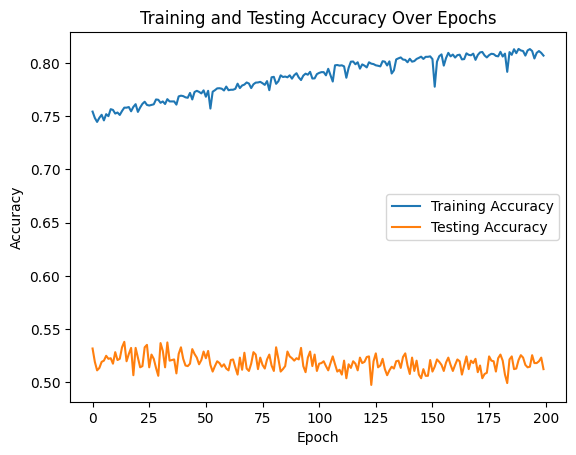

In [48]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Plot the training accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
# Plot the testing accuracy
plt.plot(hist.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()
plt.show()


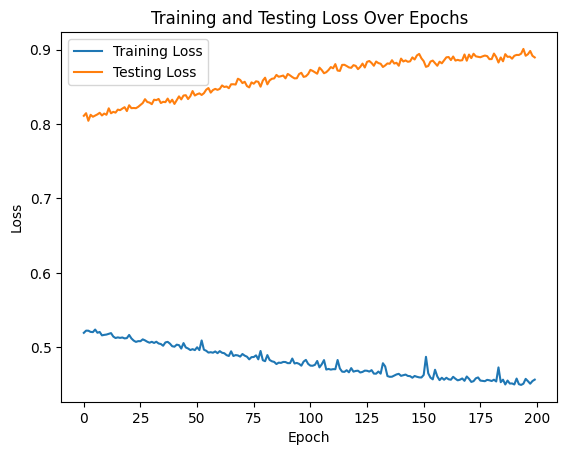

In [49]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(hist.history['loss'], label='Training Loss')
# Plot the testing loss
plt.plot(hist.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.show()
